# 1. Node Classification using Graph Convolutional Networks

## 1.1. List of GNN Python Libraries

- [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/)
    - [PyG](https://www.pyg.org/)
    - Built upon PyTorch


- Deep Graph Library ([DGL](https://www.dgl.ai/))
    - Based on PyTorch, TensorFlow or Apache MXNet.


- [Graph Nets](https://deepmind.com/research/open-source/graph-nets-library)
    - DeepMind’s library for building graph networks in Tensorflow and Sonnet


- ### [Spektral](https://graphneural.network/)
    - Based on the Keras API and TensorFlow 2
    - We will use this one for demo

In [1]:
# !pip install spektral==1.3.0

In [26]:
import numpy as np
import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt

import spektral

## 1.2. Data Loading

__Download data__ from here

- [cora labels](https://drive.google.com/file/d/1WoQZKtqIFDQEuoVbsZW_piTfWhA1qgwj/view?usp=sharing)
- [cora nodes](https://drive.google.com/file/d/12PkGTtdL5tYfPx9a3XvJ1NxxFk1KSHjP/view?usp=sharing)
- [cora edges](https://drive.google.com/file/d/1LjqHUKX1XOS-vACu0qqpmVhDYwYnWC2S/view?usp=sharing)
- [cora features](https://drive.google.com/file/d/1Cqpn5_-y0MDs-MIoltV-zaF47NyfLT1v/view?usp=sharing)
- [cora mask](https://drive.google.com/file/d/1jbJDYqfiNWeDP473w2obb-cE8_QbSTNK/view?usp=sharing)


<b>CORA dataset</b>

- This dataset is the MNIST equivalent in graph learning

- The CORA dataset consists of 2708 scientific publications classified into one of seven classes.
    - Case_Based: 298
    - Genetic_Algorithms: 418
    - Neural_Networks: 818
    - Probabilistic_Methods: 426
    - Reinforcement_Learning: 217
    - Rule_Learning: 180
    - Theory: 351


- The citation network consists of 5429 links.

- Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.

- The dictionary consists of 1433 unique words.


<nop/> <center><div style="width: 1000px;"> 
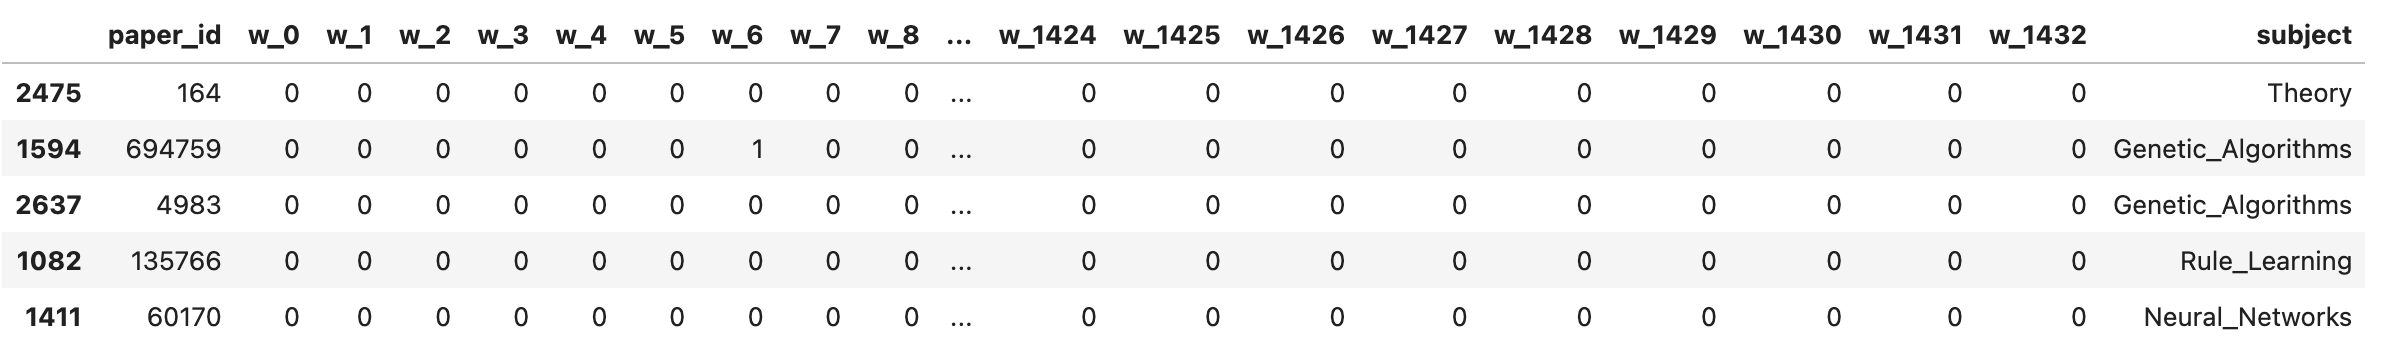</div></center>

<nop/> <center><div style="width: 250px;"> 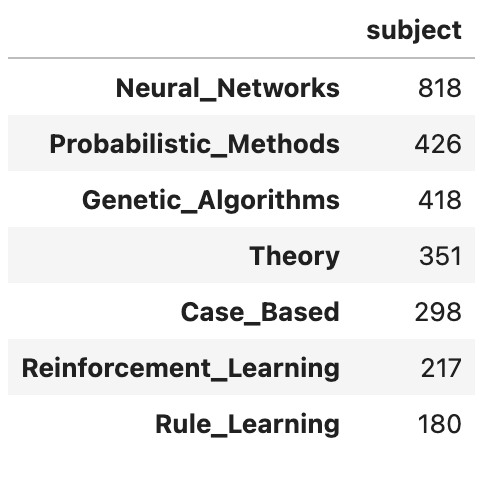
    </div></center>
<nop/> <center><div style="width: 500px;"> 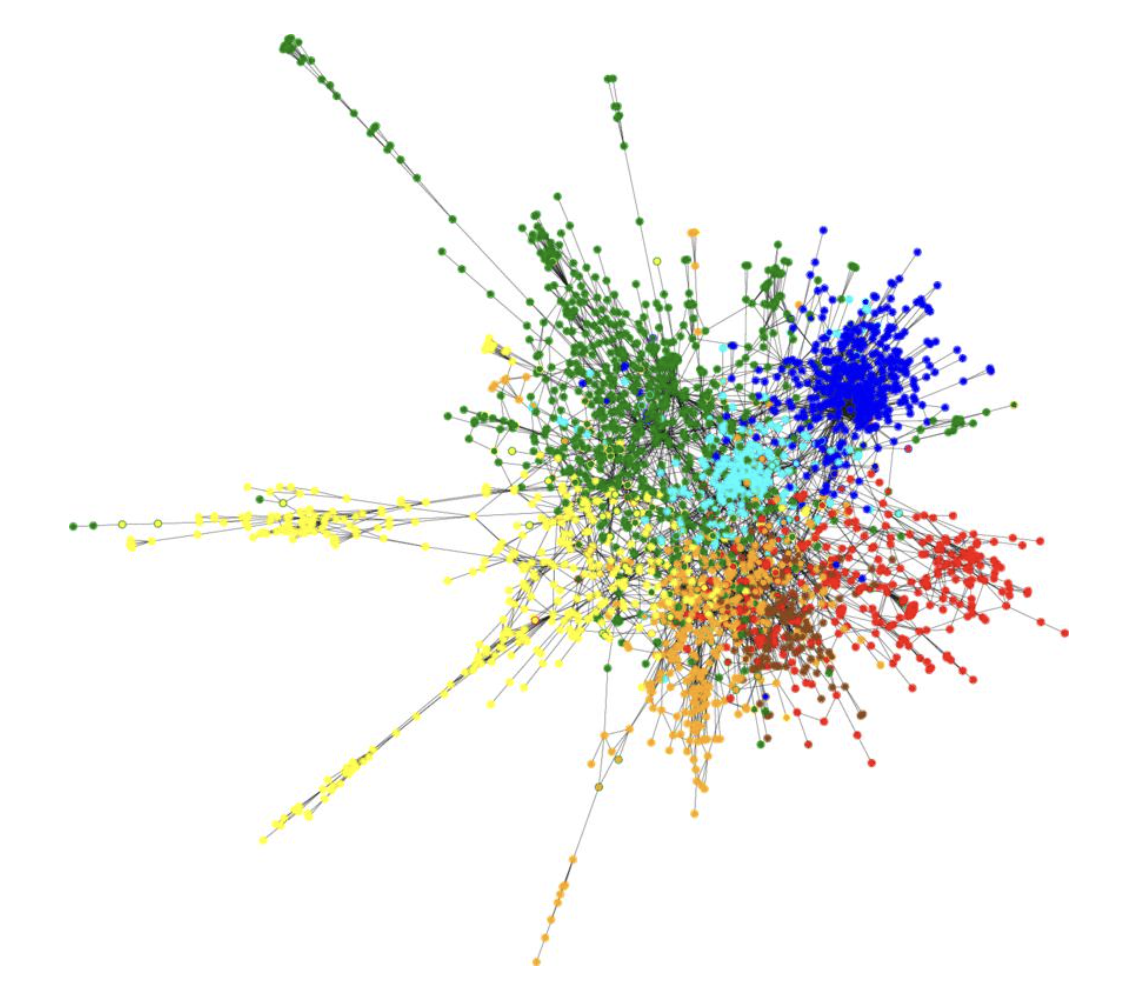
    </div></center>

#### <b>CORA data load</b>


In [3]:
nodes = np.load('./cora_nodes.npy')
edge_list = np.load('./cora_edges.npy')

labels_encoded = np.load('./cora_labels_encoded.npy')

H = np.load('./cora_features.npy')
data_mask = np.load('./cora_mask.npy')

N = H.shape[0]
F = H.shape[1]

print('H shape: ', H.shape)
print('The number of nodes (N): ', N)
print('The number of features (F) of each node: ', F)

num_classes = 7
print('The number of classes: ', num_classes)
labels_encoded.shape

H shape:  (2708, 1433)
The number of nodes (N):  2708
The number of features (F) of each node:  1433
The number of classes:  7


(2708, 7)

## 1.3. Train/Test Data Splitting

We __split train and test dataset in ratio of 7:3__, so the total number of dataset is 1895 for training, and 813 for testing.

In [4]:
# index of node for train model
train_mask = data_mask[0]

# index of node for test model
test_mask = data_mask[1]

In [5]:
print("The number of trainig data: ", np.sum(train_mask))
print("The number of test data: ", np.sum(test_mask))
test_mask

The number of trainig data:  1895
The number of test data:  813


array([False, False, False, ...,  True,  True,  True])

## 1.4. Initializing Graph G

In [6]:
G = nx.Graph(name = 'Cora')
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

## 1.5. Construct and Normalize Adjacency Matrix A

### Normalizing term , $\tilde A = \tilde D^{-1/2} (A+I) \tilde D^{-1/2}$ 

In [7]:
from scipy.linalg import fractional_matrix_power

A = nx.adjacency_matrix(G)

I = np.eye(A.shape[-1])
A_self = A + I

D = np.diag(np.array(A_self.sum(1)).flatten())
D_half_norm = fractional_matrix_power(D, -0.5)

A_half_norm = D_half_norm * A_self * D_half_norm

A_half_norm = np.array(A_half_norm)
H = np.array(H)

## 1.6. GCN Model

In [8]:
print(F, N)

1433 2708


In [25]:
from keras import layers
from keras import regularizers
from keras import models
from keras.layers import Dense

H_in = tf.keras.layers.Input(shape = (F, ))
A_in = tf.keras.layers.Input(shape = (N, ))

graph_conv_1 = spektral.layers.GCNConv(channels = 32, 
                                         activation = 'relu')([H_in, A_in])

# graph_conv_2 = spektral.layers.GCNConv(channels = 7,
#                                          activation = 'softmax')([graph_conv_1, A_in])

graph_conv_2 = spektral.layers.GCNConv(channels = 32, 
                                         activation = 'relu')([graph_conv_1, A_in])

readout = tf.keras.layers.Dense(units=7,  name="readout", activation = 'softmax', 
                                kernel_regularizer=regularizers.l2(0.001)) (graph_conv_2) 

# model = tf.keras.models.Model(inputs = [H_in, A_in], outputs = graph_conv_2)
model = models.Model(inputs = [H_in, A_in], outputs = readout)


model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2),
              loss = 'categorical_crossentropy',
              weighted_metrics = ['acc'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1433)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2708)]       0           []                               
                                                                                                  
 gcn_conv_2 (GCNConv)           (None, 32)           45888       ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 gcn_conv_3 (GCNConv)           (None, 32)           1056        ['gcn_conv_2[0][0]',       

## 1.7. Train Model

### `sample_weight = train_mask`


In [10]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, verbose=1, restore_best_weights=True)

history=model.fit([H, A_half_norm],
          labels_encoded,
          validation_data = ([H, A_half_norm], labels_encoded),
          # validation_split=0.15,
          sample_weight = train_mask,
          epochs = 300,
          batch_size = N,
          shuffle = False,
          verbose=2,
          callbacks=[es_callback])

Epoch 1/300
1/1 - 0s - loss: 1.3760 - acc: 0.1230 - val_loss: 1.8694 - val_acc: 0.3530 - 483ms/epoch - 483ms/step
Epoch 2/300
1/1 - 0s - loss: 1.3113 - acc: 0.3557 - val_loss: 1.7539 - val_acc: 0.3275 - 53ms/epoch - 53ms/step
Epoch 3/300
1/1 - 0s - loss: 1.2297 - acc: 0.3282 - val_loss: 1.6190 - val_acc: 0.3327 - 51ms/epoch - 51ms/step
Epoch 4/300
1/1 - 0s - loss: 1.1340 - acc: 0.3340 - val_loss: 1.4715 - val_acc: 0.3999 - 54ms/epoch - 54ms/step
Epoch 5/300
1/1 - 0s - loss: 1.0290 - acc: 0.4063 - val_loss: 1.3057 - val_acc: 0.5609 - 48ms/epoch - 48ms/step
Epoch 6/300
1/1 - 0s - loss: 0.9110 - acc: 0.5699 - val_loss: 1.1404 - val_acc: 0.6976 - 50ms/epoch - 50ms/step
Epoch 7/300
1/1 - 0s - loss: 0.7933 - acc: 0.7055 - val_loss: 0.9784 - val_acc: 0.8117 - 51ms/epoch - 51ms/step
Epoch 8/300
1/1 - 0s - loss: 0.6785 - acc: 0.8158 - val_loss: 0.8229 - val_acc: 0.8475 - 57ms/epoch - 57ms/step
Epoch 9/300
1/1 - 0s - loss: 0.5690 - acc: 0.8512 - val_loss: 0.6862 - val_acc: 0.8700 - 58ms/epoch - 

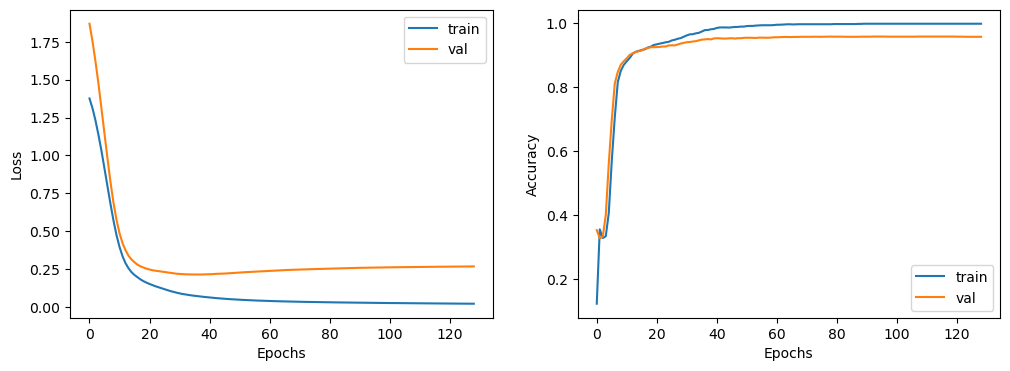

In [11]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "val"], loc="best")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "val"], loc="best")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()
    
display_learning_curves(history)

## 1.8. Model Evaluation

In [12]:
y_pred = model.evaluate([H, A_half_norm],
                        labels_encoded,
                        sample_weight = test_mask,
                        batch_size = N)

1/1 [==============================] - 0s 77ms/step - loss: 0.2395 - acc: 0.8672


## 1.9. T-SNE

- __Training Model__

    - `model = models.Model(inputs = [H_in, A_in], outputs = readout)`

- __output comes from last readout layer__

In [13]:
activations = model.predict([H,A_half_norm],batch_size = N)

1/1 [==============================] - 0s 56ms/step


In [14]:
activations

array([[6.1872572e-04, 1.4539839e-10, 1.2205218e-08, ..., 9.9938118e-01,
        4.2923627e-08, 1.1646765e-12],
       [3.3842911e-12, 8.4428298e-12, 2.5148575e-12, ..., 2.0673039e-16,
        4.3926009e-11, 5.5286808e-08],
       [2.3548187e-08, 5.9403815e-09, 4.2154660e-08, ..., 2.4962378e-12,
        1.5469732e-07, 9.6182802e-08],
       ...,
       [3.1101959e-09, 4.4644580e-08, 9.9999714e-01, ..., 2.5845820e-06,
        8.7712813e-08, 6.9461148e-10],
       [3.5007586e-10, 1.4247134e-07, 2.8913050e-08, ..., 7.3713646e-10,
        4.1575707e-10, 9.9999976e-01],
       [5.7663140e-08, 3.7921887e-05, 6.4091861e-01, ..., 1.1892490e-07,
        2.1450091e-07, 3.5902750e-01]], dtype=float32)

- __Generation of output layer from molde.layers__
- __Gives output from each layer__
- __select output from second layer__

In [15]:
model.input

[<KerasTensor: shape=(None, 1433) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 2708) dtype=float32 (created by layer 'input_2')>]

In [16]:
model.layers

In [17]:
from sklearn.manifold import TSNE

layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict([H,A_half_norm],batch_size = N)

1/1 [==============================] - 0s 45ms/step


In [18]:
type(activations)
activations[2]

array([[0.76339424, 1.4134357 , 2.2534626 , ..., 2.4013631 , 0.66487414,
        2.9469442 ],
       [2.4074466 , 0.        , 0.03963277, ..., 1.0232929 , 2.865633  ,
        0.8648594 ],
       [1.8930701 , 0.4133031 , 0.3569261 , ..., 0.8545511 , 2.0953388 ,
        0.48810428],
       ...,
       [1.5608234 , 2.0171652 , 2.2913792 , ..., 1.5146935 , 0.8614522 ,
        0.25916082],
       [1.8266032 , 0.08385246, 0.        , ..., 2.1032345 , 2.3629425 ,
        0.        ],
       [1.7981237 , 1.3837584 , 0.88148624, ..., 1.7456326 , 1.8002809 ,
        0.        ]], dtype=float32)

In [19]:
x_tsne = TSNE(n_components = 2).fit_transform(activations[2])

/Users/sulee/opt/anaconda3/envs/py37tf2SG/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/sulee/opt/anaconda3/envs/py37tf2SG/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [20]:
x_tsne

array([[ 36.941696 , -29.795565 ],
       [-35.106037 ,  47.260162 ],
       [-20.927883 ,  38.861187 ],
       ...,
       [-46.469532 , -13.020327 ],
       [ 13.634301 ,  23.983332 ],
       [-35.27871  ,   1.4451513]], dtype=float32)

In [21]:
print(labels_encoded[0])

[0. 0. 0. 0. 1. 0. 0.]


In [22]:
color_map = np.argmax(labels_encoded, axis = 1)
color_map

array([4, 3, 3, ..., 2, 6, 2])

In [23]:
np.where(color_map == 4)

(array([   0,    3,    5,   13,   29,   34,   68,   79,   82,   84,   88,
          96,  115,  128,  156,  172,  178,  182,  203,  207,  212,  221,
         240,  241,  243,  255,  272,  284,  288,  317,  337,  350,  352,
         369,  393,  394,  411,  413,  425,  437,  439,  448,  449,  457,
         458,  468,  480,  484,  505,  508,  519,  527,  539,  563,  612,
         661,  671,  677,  684,  694,  703,  704,  713,  714,  727,  736,
         739,  745,  747,  755,  769,  775,  789,  793,  807,  808,  824,
         839,  846,  865,  869,  871,  877,  881,  886,  889,  900,  919,
         949,  956,  984, 1000, 1037, 1040, 1041, 1047, 1048, 1061, 1072,
        1123, 1131, 1138, 1140, 1156, 1172, 1177, 1203, 1215, 1224, 1229,
        1253, 1259, 1262, 1283, 1291, 1296, 1346, 1355, 1356, 1369, 1384,
        1386, 1395, 1396, 1412, 1422, 1429, 1457, 1466, 1476, 1478, 1496,
        1522, 1536, 1537, 1569, 1587, 1622, 1628, 1637, 1676, 1685, 1707,
        1713, 1730, 1731, 1733, 1742, 

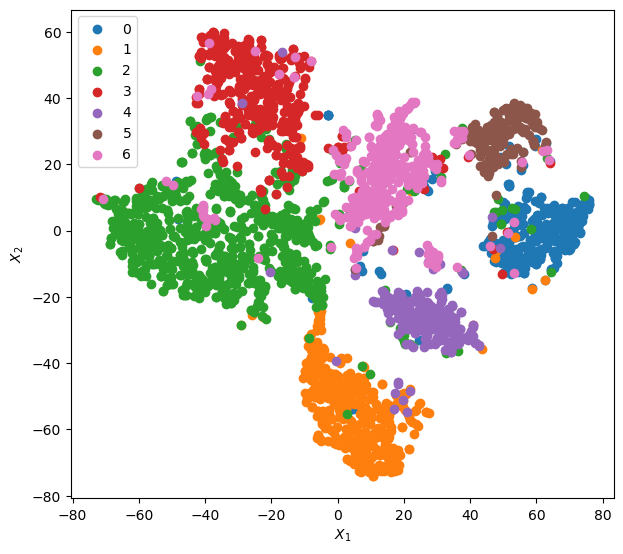

In [24]:
def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis = 1)
    plt.figure(figsize = (7,7))
    plt.axes().set_aspect('equal')
    plt.xlabel("$X_1$")
    plt.ylabel("$X_2$")
    for cl in range(num_classes):
        indices = np.where(color_map == cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label = cl)
    plt.legend()
    plt.show()

plot_tSNE(labels_encoded,x_tsne)